In [30]:
from sctoolbox.utilities import bgcolor

# QC and filtering
<hr style="border:2px solid black"> </hr>

**Quality control**

"We must ensure that all cellular barcode data correspond to viable cells.

Cell QC is commonly performed based on three QC covariates: the number of counts per barcode (count depth), the number of genes per barcode, and the fraction of counts from mitochondrial genes per barcode.

The distributions of these QC covariates are examined for outlier peaks that are filtered out by thresholding.

These outlier barcodes can correspond to dying cells, cells whose membranes are broken, or doublets".

Samples with a low count depth, few detected genes, and a high fraction of mitochondrial counts are indicative of cells whose cytoplasmic mRNA has leaked out through a broken membrane.

In contrast, cells with unexpectedly high counts and a large number of detected genes may represent doublets.

**DOI: 10.15252/msb.20188746**

<hr style="border:2px solid black"> </hr>
<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [31]:
%bgcolor PowderBlue

# Set the species of the data
species = "human"

# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "sample"

# Set the column in adata.var containing gene names (or set to None to use adata.var index)
gene_column = None

# Decide the sex of each sample
predict_sex = True
female_gene = "Xist"

# Decide whether to remove doublets using scrublet (True) or to skip doublet calculation (False)
filter_doublets = True
threads = 4
doublet_threshold = 0.2

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = False

# Removal of gene subsets
filter_mito = True
filter_ribo = False
filter_gender = False

<hr style="border:2px solid black"> </hr>

## Setup

In [5]:
#####################IMPORTING PACKAGES#############################
import sctoolbox.utilities as utils
import sctoolbox.marker_genes as marker_genes
import sctoolbox.analyser as analyser
import sctoolbox.qc_filter as qc
import sctoolbox.plotting as pl

## Load anndata
Uses anndata object written by the previous notebook.

In [6]:
adata = utils.load_anndata(is_from_previous_note=True, which_notebook=1, data_to_evaluate=condition_column)
display(adata)

AnnData object with n_obs × n_vars = 5000 × 26128
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype'
    uns: 'color_set', 'infoprocess'

In [7]:
#Ensure that condition column is a category
adata.obs[condition_column] = adata.obs[condition_column].astype("category")

In [8]:
figure_path = adata.uns["infoprocess"]["Anndata_path"] + "/"

## Label genes
Mark genes on their general association. E.g. mitochondrial.

In [9]:
marker_genes.label_genes(adata, gene_column=gene_column, species=species)

display(adata.uns["infoprocess"]["genes_labeled"])

['is_ribo', 'is_mito', 'is_gender']

## Calculate QC metrics
Create quality control metrics to filter the data on.

In [10]:
# If control_var=True, include gene labels from in qc computation
# TODO can't be disabled at the moment
adata = analyser.calculate_qc_metrics(adata, qc_vars=adata.uns["infoprocess"]["genes_labeled"])

## Calculate doublet scores

Sending 7 batches to 4 threads


Scrublet per group:   0%|          | 0/7 [00:00<?, ?it/s]

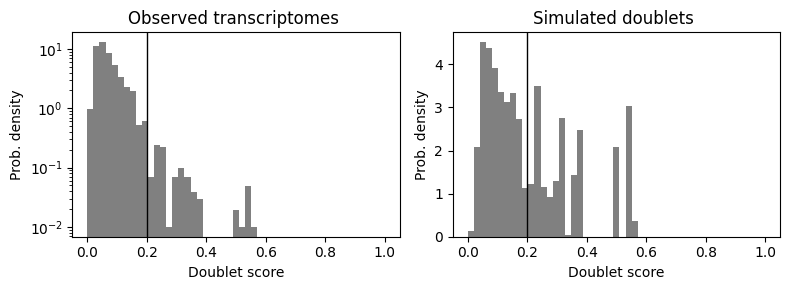

Filtered out 96 cells from adata. New number of cells is: 4904


In [11]:
if filter_doublets:
    
    qc.estimate_doublets(adata, groupby=condition_column, threads=threads, threshold=doublet_threshold)
    
    #Remove the duplicates from adata
    qc.filter_cells(adata, "predicted_doublet", remove_bool=True)

## Predict sex per sample

Normalizing adata
Estimating male/female per group
Plotting violins


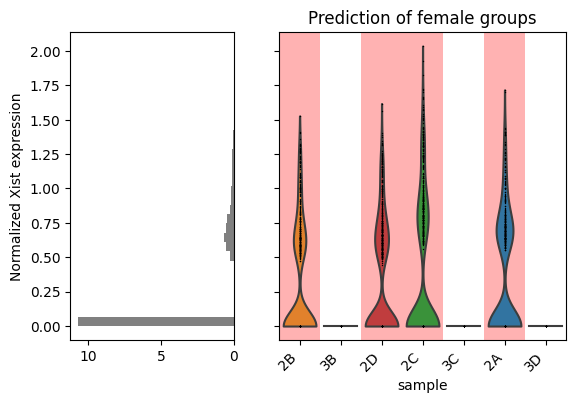

In [12]:
if predict_sex:
    qc.predict_sex(adata, gene=female_gene, 
                          groupby=condition_column, 
                          gene_column=gene_column, 
                          save=figure_path + "female_prediction.png")

------------------

## Cell filtering

Low and high count depth indicates cells with low integrity and doublets, respectively (DOI: 10.15252/msb.20188746).

In [13]:
# Choose columns to be used for filtering
obs_columns = ["n_genes_by_counts", "log1p_total_counts"]
obs_columns += ["pct_counts_" + var for var in adata.uns["infoprocess"]["genes_labeled"] if var != "is_gender"]
obs_columns

['n_genes_by_counts',
 'log1p_total_counts',
 'pct_counts_is_ribo',
 'pct_counts_is_mito']

### Estimate initial thresholds automatically

In [14]:
groupby = condition_column if global_threshold is False else None
initial_thresholds = qc.automatic_thresholds(adata, which="obs", groupby=groupby, columns=obs_columns)
qc.thresholds_as_table(initial_thresholds) # show thresholds

,Parameter,Group,Minimum,Maximum
0,n_genes_by_counts,2A,405.252544,949.779722
1,n_genes_by_counts,2B,272.117995,926.086762
2,n_genes_by_counts,2C,274.003392,532.586969
3,n_genes_by_counts,2D,296.133704,921.360082
4,n_genes_by_counts,3B,317.753616,1144.850551
5,n_genes_by_counts,3C,409.382860,902.522442
6,n_genes_by_counts,3D,283.805647,996.055788
7,log1p_total_counts,2A,6.373046,7.047137
8,log1p_total_counts,2B,6.487980,7.255464
9,log1p_total_counts,2C,5.974850,6.671568


### Customize thresholds via sliders

 (Rerun cell if plot is not shown)

In [15]:
%matplotlib widget
%bgcolor PowderBlue

#Plot violins and sliders
obs_figure, obs_slider_dict = qc.quality_violin(adata, obs_columns,
                                            groupby=condition_column,
                                            which="obs",
                                            thresholds=initial_thresholds,
                                            global_threshold=global_threshold,
                                            title="Cell quality control (before)",
                                            save=figure_path + "cell_filtering.png")
obs_figure

In [16]:
# Get final thresholds
final_thresholds = qc.get_slider_thresholds(obs_slider_dict)
qc.thresholds_as_table(final_thresholds) # show thresholds

,Parameter,Group,Minimum,Maximum
0,n_genes_by_counts,2A,405.252544,949.779722
1,n_genes_by_counts,2B,308.000000,926.086762
2,n_genes_by_counts,2C,308.000000,532.586969
3,n_genes_by_counts,2D,308.000000,921.360082
4,n_genes_by_counts,3B,317.753616,1144.850551
5,n_genes_by_counts,3C,409.382860,902.522442
6,n_genes_by_counts,3D,308.000000,996.055788
7,log1p_total_counts,2A,6.373046,7.047137
8,log1p_total_counts,2B,6.487980,7.255464
9,log1p_total_counts,2C,5.998937,6.671568


### Apply final thresholds
Filter the anndata object based on the thresholds in the threshold table.

In [17]:
qc.apply_qc_thresholds(adata, which="obs", thresholds=final_thresholds, groupby=groupby)

Filtering based on 'n_genes_by_counts' from 4904 -> 3975 cells
Filtering based on 'log1p_total_counts' from 3975 -> 3632 cells
Filtering based on 'pct_counts_is_ribo' from 3632 -> 3278 cells
Filtering based on 'pct_counts_is_mito' from 3278 -> 2778 cells


### Show data after filtering

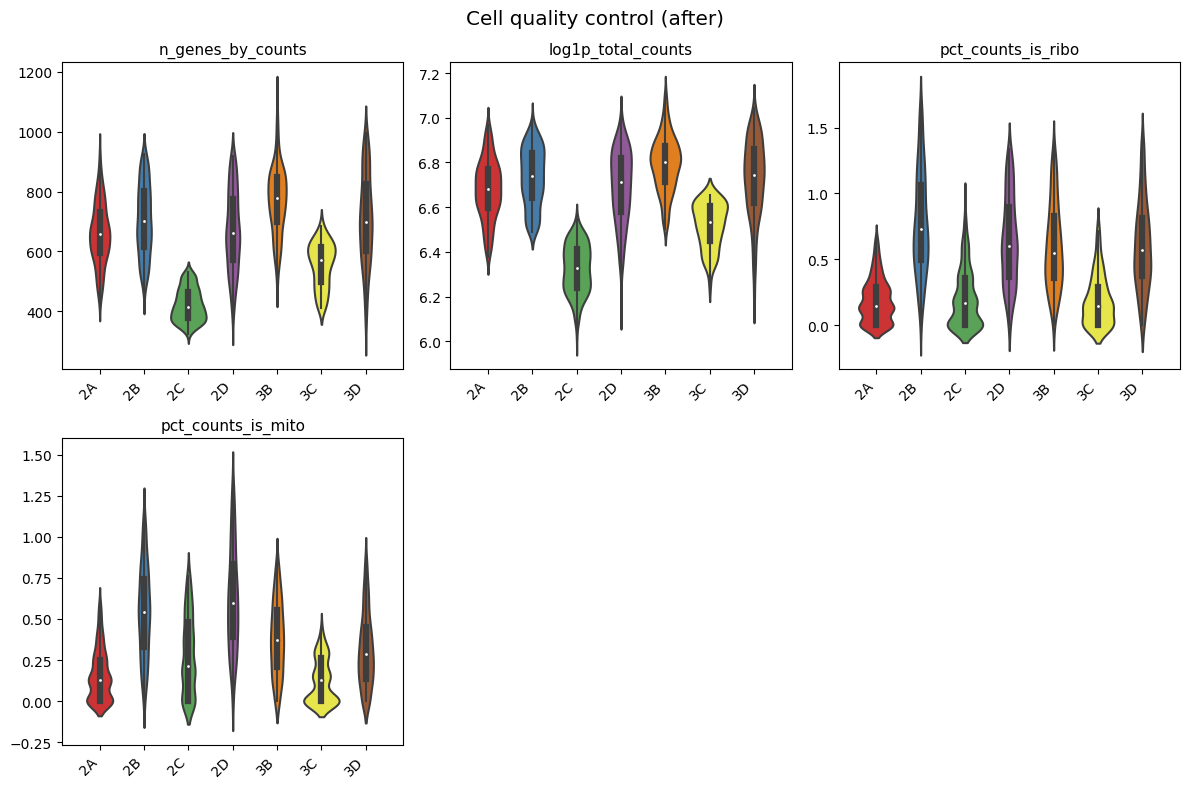

In [18]:
%matplotlib inline 

#Plot violins and sliders
figure, slider_dict = qc.quality_violin(adata, obs_columns,
                                     groupby=condition_column,
                                     which="obs", ncols=3,
                                     global_threshold = global_threshold,
                                     title="Cell quality control (after)",
                                     save=figure_path + "cell_filtering_final.png")
figure

-------------------

## Gene filtering

In [19]:
#Recalculate quality measures for genes
adata = analyser.calculate_qc_metrics(adata)

In [20]:
#Remove genes with 0 count
zero_bool = adata.var["n_cells_by_counts"] == 0
adata = adata[:,~zero_bool]

In [21]:
#Choose columns for quality control
var_columns = ["n_cells_by_counts", "log1p_mean_counts"]

### Customize thresholds via sliders

 (Rerun cell if plot is not shown)

In [22]:
%matplotlib widget
%bgcolor PowderBlue

#Plot violins and sliders
var_figure, var_slider_dict = qc.quality_violin(adata, var_columns,
                                            which="var",
                                            title="Gene quality control (before)",
                                            save=figure_path + "gene_filtering.png")
var_figure

### Apply gene filtering

In [23]:
# Get final thresholds
final_thresholds = qc.get_slider_thresholds(var_slider_dict)
qc.thresholds_as_table(final_thresholds) # show thresholds

,Parameter,Minimum,Maximum
0,n_cells_by_counts,1.00000,2566.000000
1,log1p_mean_counts,0.00036,1.144691


In [24]:
qc.apply_qc_thresholds(adata, which="var", thresholds=final_thresholds)

Filtering based on 'n_cells_by_counts' from 21171 -> 21171 .var features
Filtering based on 'log1p_mean_counts' from 21171 -> 21171 .var features


In [25]:
adata

AnnData object with n_obs × n_vars = 2778 × 21171
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'doublet_score', 'predicted_doublet', 'predicted_sex'
    var: 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'scrublet'

### Show data after filtering

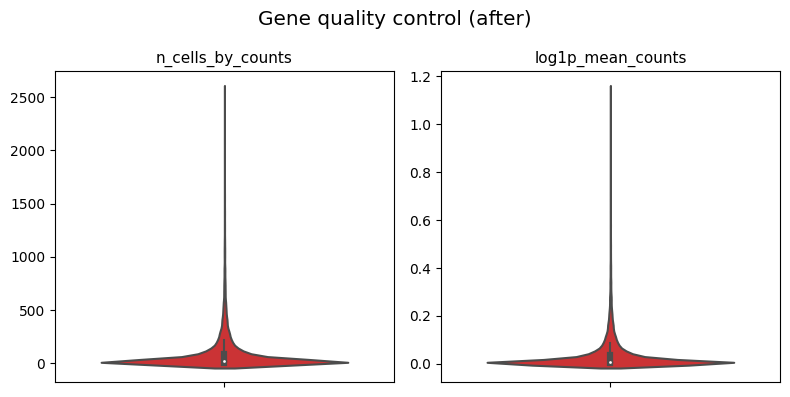

In [26]:
%matplotlib inline 

#Plot violins and sliders
figure, slider_dict = qc.quality_violin(adata, var_columns,
                                        which="var", ncols=3,
                                        title="Gene quality control (after)",
                                        save=figure_path + "gene_filtering_final.png")
figure

### Filter additional marked genes
Remove genes that are labeled as e.g. mitochondrial genes.

In [27]:
#Remove mitochrondrial genes
if filter_mito is True:
    print("Removing mitochrondrial genes:")
    qc.filter_genes(adata, "is_mito")

#Remove ribosomal genes
if filter_ribo is True:
    print("Removing ribosomal genes:")
    qc_filter_genes(adata, "is_ribo")

#Remove gender genes    
if filter_gender is True:
    print("Removing gender genes:")
    qc.filter_genes(adata, "is_gender")

#Remove custom genes from list
#adata4 = qc.filter_genes(adata3, "is_custom")

Removing mitochrondrial genes:
Filtered out 13 genes from adata. New number of genes is: 21158


-------------

## Save filtered adata
Store the final results

In [28]:
adata

AnnData object with n_obs × n_vars = 2778 × 21158
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'doublet_score', 'predicted_doublet', 'predicted_sex'
    var: 'is_ribo', 'is_mito', 'cellcycle', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'color_set', 'infoprocess', 'scrublet'

In [29]:
utils.saving_anndata(adata, current_notebook=2)

Your new anndata object is saved here: pipeline_output/results/Test1/anndata_2_Test1.h5ad
